In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv(r'ml_data_cleaned.csv')

In [3]:
# seeing statistical summary for numerical data
data.describe()

,Quantity,UnitPrice
count,3.487815e+06,3.487815e+06
mean,5.299238e+01,1.093264e+03
std,3.030330e+01,4.875023e+02
min,1.000000e+00,1.199900e+02
25%,2.700000e+01,6.821400e+02
50%,5.300000e+01,1.096860e+03
75%,7.900000e+01,1.493010e+03
max,1.050000e+02,1.948810e+03


In [5]:
# statistical summary for categorical data
data.describe(include='object')

,TransactionDate,OrderID,PaymentMethod,SalesChannel,ProductName,Category,CustomerCountry,CustomerDateOfBirth,CustomerGender,CustomerFirstName,CustomerLastName,CustomerCity,CustomerSignupDate
count,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815,3487815
unique,1670,3487813,6,2,16,7,10,17531,2,690,1000,51,1096
top,2024-12-06,O2133963,Cash,In-Store,Microphone,Audio Devices,Germany,1959-03-26,Male,Michael,Smith,Unknown,2024-12-03
freq,2241,2,935403,1744439,356480,977081,350757,428,1747057,80275,75482,69716,3711


### Exploratory Data Analysis

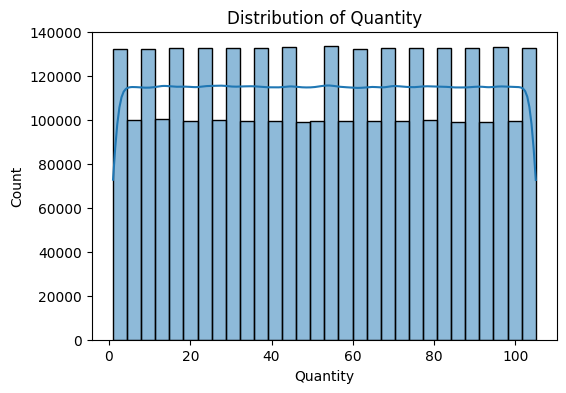

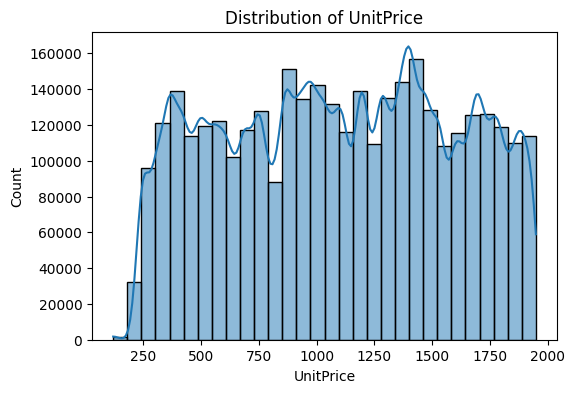

In [ ]:
# Univariate Analysis
numerical_cols = ['Quantity', 'UnitPrice']

# Histogram plots
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

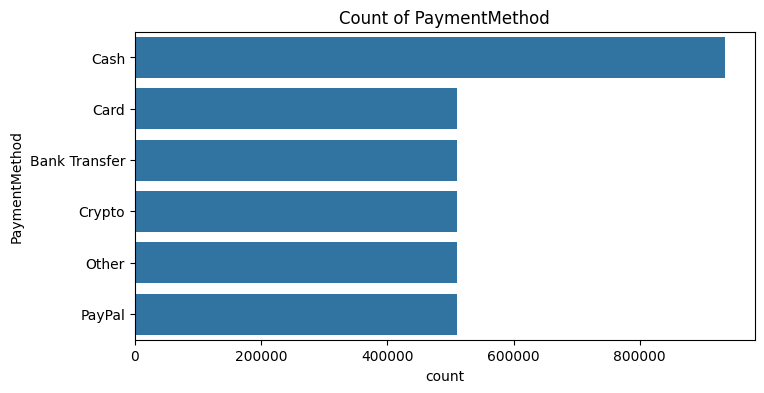

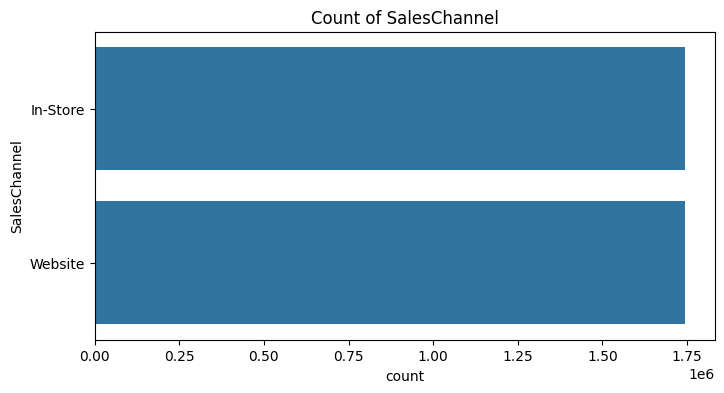

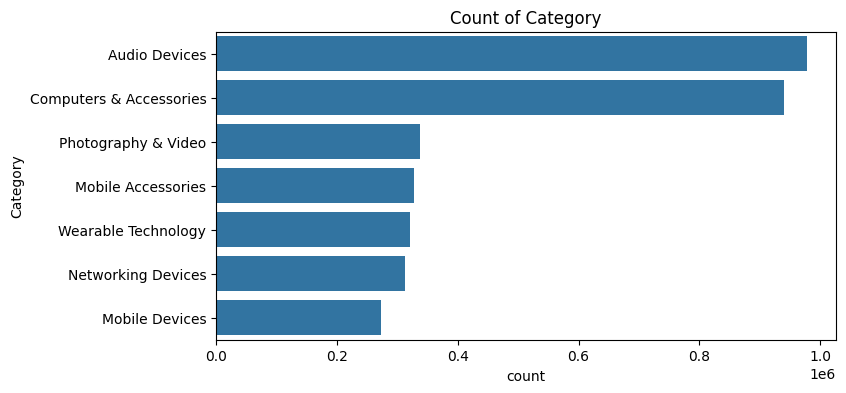

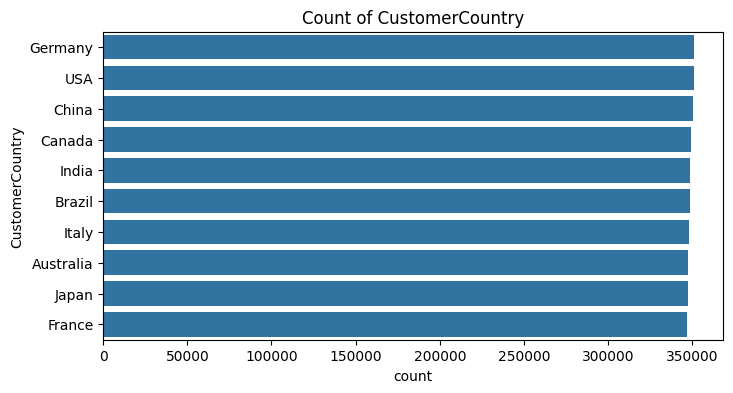

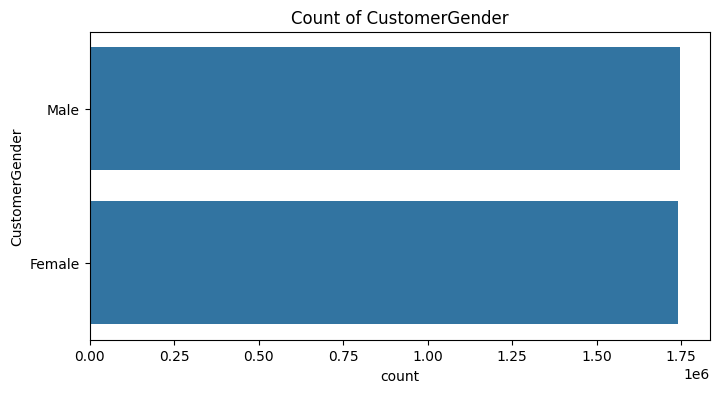

In [ ]:
categorical_cols = ['PaymentMethod', 'SalesChannel', 'Category', 
                    'CustomerCountry', 'CustomerGender']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=data[col], order=data[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.show()


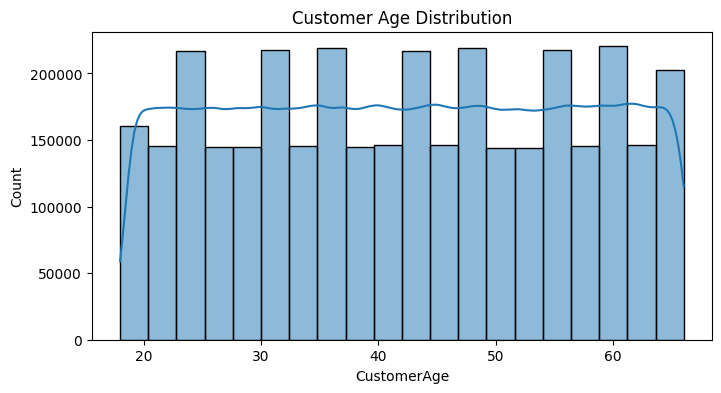

In [ ]:
# Calculate age column from CustomerDateOfBirth
data['CustomerDateOfBirth'] = pd.to_datetime(data['CustomerDateOfBirth'], errors='coerce')
data['CustomerAge'] = datetime.today().year - data['CustomerDateOfBirth'].dt.year

# Plot age distribution
plt.figure(figsize=(8,4))
sns.histplot(data['CustomerAge'], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.show()


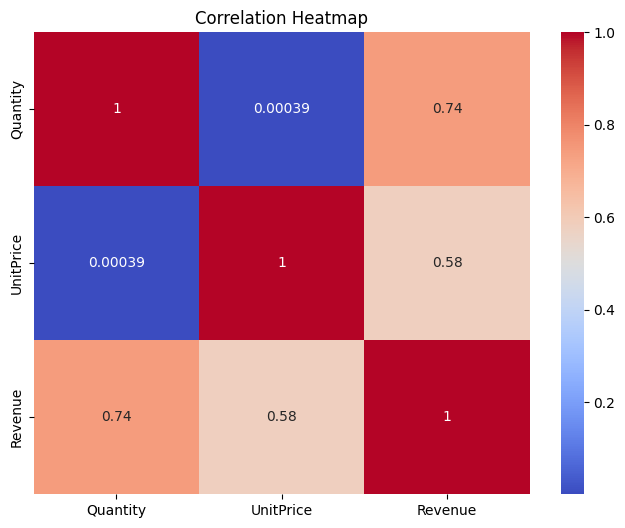

In [ ]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']

plt.figure(figsize=(8,6))
sns.heatmap(data[['Quantity', 'UnitPrice', 'Revenue']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


#### Explanatory Analysis

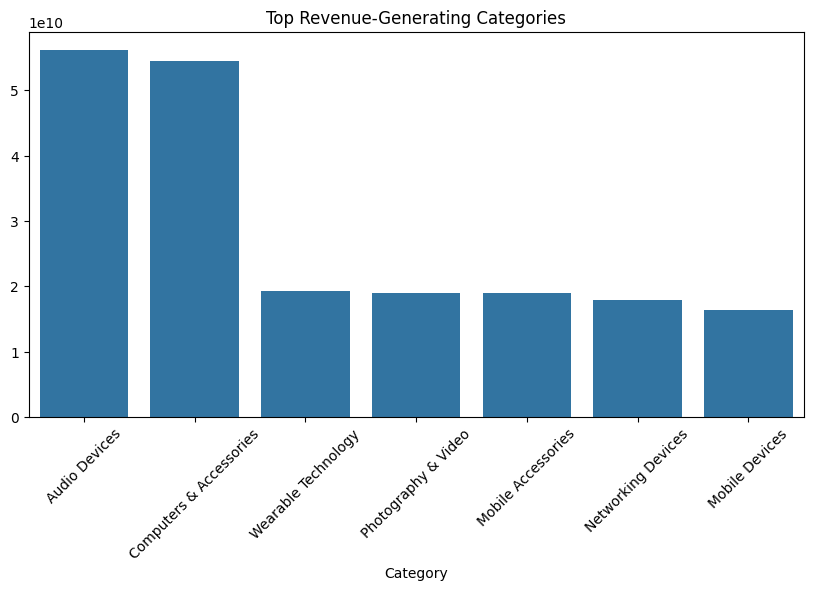

In [ ]:
# Top-selling categories
top_categories = data.groupby('Category')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.xticks(rotation=45)
plt.title("Top Revenue-Generating Categories")
plt.show()


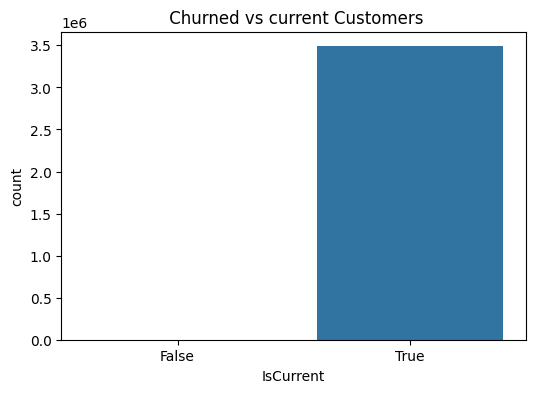

In [ ]:
# Churn analysis
plt.figure(figsize=(6,4))
sns.countplot(x=data['IsCurrent'])
plt.title(" Churned vs current Customers")
plt.show()


Analysis to get Low valued customers by Revenue Generated

       CustomerFirstName CustomerLastName CustomerCity  Revenue
469169            Regina          Jackson      Hamburg   372.55
365019              Lisa             King      Hamburg   367.63
181490         Elizabeth           Morris     Brasília   367.61
586738           William          Collins       Mumbai   351.84
250474          Jennifer        Armstrong       Sydney   335.85
124143            Connie           Turner     Brisbane   313.25
75486              Brian             Horn    Vancouver   291.98
358290            Leslie            Hardy        Perth   258.46
200724           Garrett              Cox     Shenzhen   244.06
581030           Vincent              Lee    Frankfurt   232.48


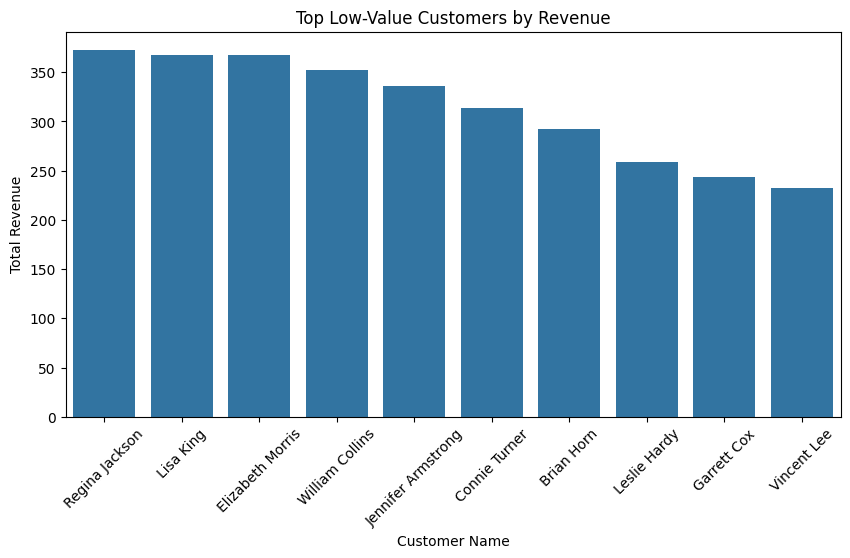

In [ ]:
customer_revenue = data.groupby(['CustomerFirstName', 'CustomerLastName', 'CustomerCity'])['Revenue'].sum().reset_index()

# Sort by Lowest revenue
low_customers = customer_revenue.sort_values(by='Revenue', ascending=False).tail(10)

# Display top 10 Low-value customers
print(low_customers)

# Visualize top customer
plt.figure(figsize=(10,5))
sns.barplot(y=low_customers['Revenue'], x=low_customers['CustomerFirstName'] + " " + low_customers['CustomerLastName'])
plt.xticks(rotation=45)
plt.title("Top Low-Value Customers by Revenue")
plt.ylabel("Total Revenue")
plt.xlabel("Customer Name")
plt.show()

### Performing Customer Segmentation by 

calculate RFM-Score

In [ ]:
# Initialize MinMaxScaler to normalize the rfm data
scaler = MinMaxScaler()

# Convert TransactionDate to datetime
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')

# Calculate RFM metrics
rfm = data.groupby(['CustomerFirstName', 'CustomerLastName']).agg(
    Recency=('TransactionDate', lambda x: (pd.to_datetime('today') - x.max()).days),
    Frequency=('OrderID', 'count'),
    Monetary=('Revenue', 'sum')
).reset_index()

# Normalize the RFM metrics
rfm[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# calculate rfm score
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']

# Display the first few rows of the RFM dataframe
rfm.head(10)

,CustomerFirstName,CustomerLastName,Recency,Frequency,Monetary,RFM_Score
0,Aaron,Abbott,0.109047,0.004174,0.005307,0.118529
1,Aaron,Acosta,0.137208,0.002385,0.005282,0.144875
2,Aaron,Adams,0.061714,0.020871,0.020119,0.102703
3,Aaron,Adkins,0.314560,0.002385,0.003855,0.320800
4,Aaron,Aguilar,0.060515,0.014311,0.016460,0.091287


In [ ]:
rfm['fullName'] = rfm['CustomerFirstName'] + " " + rfm['CustomerLastName']

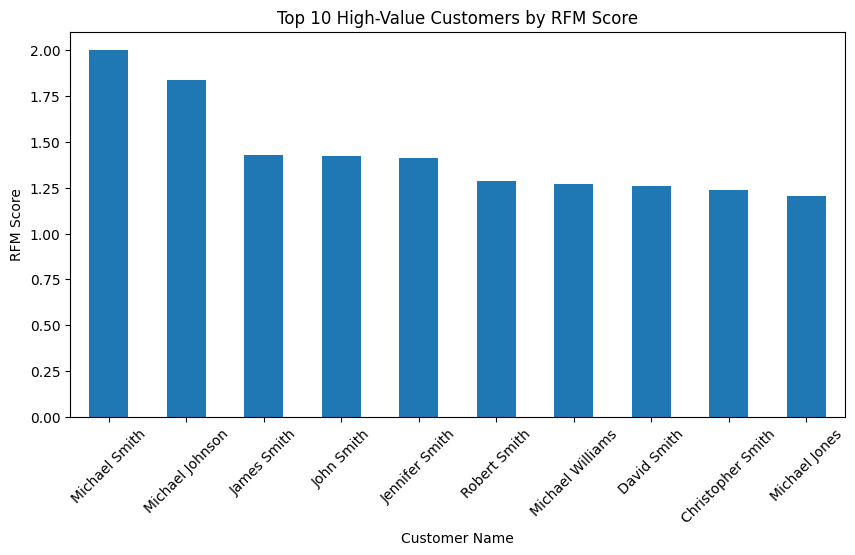

In [ ]:
customer_rfm = rfm.groupby(['fullName'])['RFM_Score'].sum().reset_index()
top_customers_by_rfm = customer_rfm.sort_values(by='RFM_Score', ascending=False).head(10)
top_customers_by_rfm.plot(kind='bar', x='fullName', y='RFM_Score', legend=False, figsize=(10, 5))
plt.title("Top 10 High-Value Customers by RFM Score")
plt.ylabel("RFM Score")
plt.xlabel("Customer Name")
plt.xticks(rotation=45)
plt.show()

#### Categorize customers to high value, low value and normal customers based on RFM scores

In [ ]:
# Define thresholds for segmentation (based on RFM Score percentiles)
high_value_threshold = rfm['RFM_Score'].quantile(0.67)
low_value_threshold = rfm['RFM_Score'].quantile(0.33)

# Segment customers based on RFM score
def segment_customer_rfm(row):
    if row['RFM_Score'] >= high_value_threshold:
        return 'High Valued Customer'
    elif row['RFM_Score'] <= low_value_threshold:
        return 'Low Value Customer'
    else:
        return 'Normal Customer'

# Apply segmentation
rfm['CustomerSegment'] = rfm.apply(segment_customer_rfm, axis=1)

# Display the first few rows with customer segments
rfm.head()

,CustomerFirstName,CustomerLastName,Recency,Frequency,Monetary,RFM_Score,CustomerSegment
0,Aaron,Abbott,0.109047,0.004174,0.005307,0.118529,Normal Customer
1,Aaron,Acosta,0.137208,0.002385,0.005282,0.144875,High Valued Customer
2,Aaron,Adams,0.061714,0.020871,0.020119,0.102703,Normal Customer
3,Aaron,Adkins,0.314560,0.002385,0.003855,0.320800,High Valued Customer
4,Aaron,Aguilar,0.060515,0.014311,0.016460,0.091287,Normal Customer


In [ ]:
# merge RFM with original data
data = data.merge(rfm, on=['CustomerFirstName', 'CustomerLastName'], how='left')

#### Visualizing distribution of customer segments

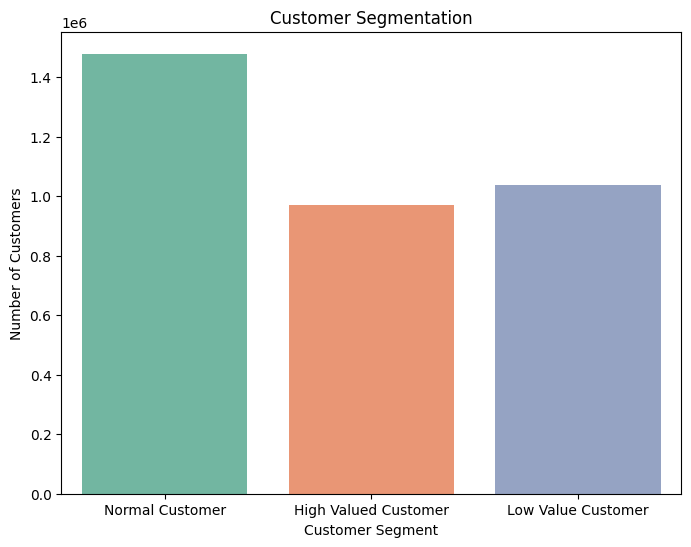

In [ ]:
# Bar plot for customer segments
plt.figure(figsize=(8, 6))
sns.countplot(x='CustomerSegment', data=data, palette='Set2')
plt.title('Customer Segmentation')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.show()


##### computing summary statistics of low value against high value customers

In [ ]:
low_value_customers = data[data['CustomerSegment'] == 'Low Value Customer']
high_value_customers = data[data['CustomerSegment'] == 'High Valued Customer']

high_value_customers.describe(include='object')

,OrderID,PaymentMethod,SalesChannel,ProductName,Category,CustomerCountry,CustomerGender,CustomerFirstName,CustomerLastName,CustomerCity,CustomerSignupDate,CustomerSegment
count,971719,971719,971719,971719,971719,971719,971719,971719,971719,971719,971719,971719
unique,971719,6,2,16,7,10,2,690,1000,51,1096,1
top,O1000001,Cash,In-Store,Microphone,Audio Devices,Germany,Male,Michael,Smith,Frankfurt,2022-10-30,High Valued Customer
freq,1,260703,486613,99516,272323,98352,486977,42938,56438,19712,1112,971719


### Understanding low valued Customers to proffer recommendations

In [ ]:
# Summary statistics for low-value customers
low_value_summary = low_value_customers[['Revenue', 'Frequency', 'Monetary', 'Recency', 'CustomerAge']].describe()
print(low_value_summary)


            Revenue     Frequency      Monetary       Recency   CustomerAge
count  1.036781e+06  1.036781e+06  1.036781e+06  1.036781e+06  1.036781e+06
mean   5.741432e+04  1.114242e-02  1.175372e-02  1.714835e-02  4.232547e+01
std    4.434144e+04  6.665129e-03  6.856061e-03  1.334820e-02  1.388866e+01
min    1.199900e+02  0.000000e+00  1.272497e-06  0.000000e+00  1.800000e+01
25%    2.151058e+04  5.963029e-03  6.177617e-03  5.991612e-03  3.000000e+01
50%    4.630880e+04  1.013715e-02  1.050807e-02  1.437987e-02  4.200000e+01
75%    8.512944e+04  1.550388e-02  1.636139e-02  2.636309e-02  5.400000e+01
max    2.046250e+05  3.279666e-02  3.388644e-02  5.991612e-02  6.600000e+01


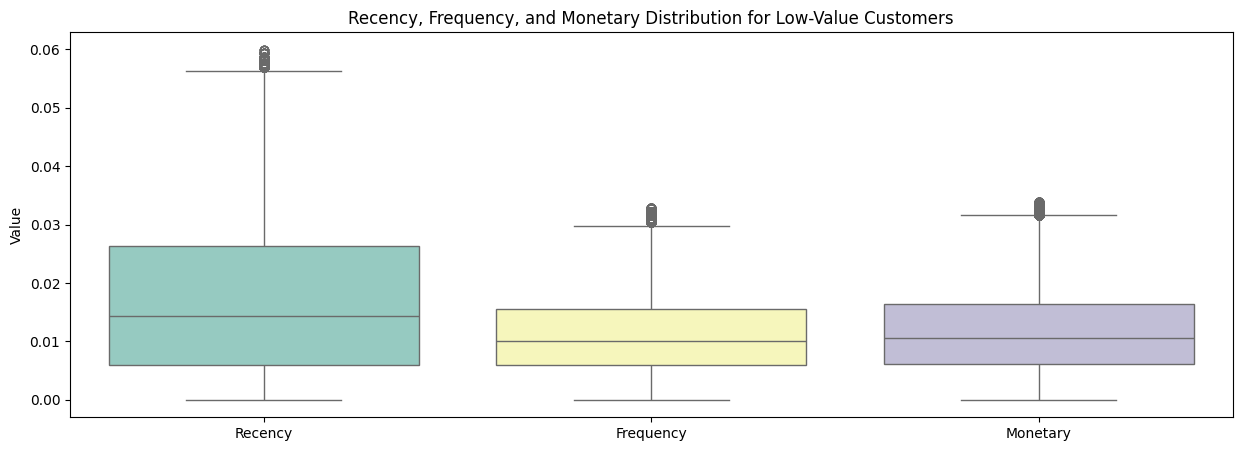

In [ ]:
# Boxplot for Recency, Frequency, and Monetary for low-value customers
plt.figure(figsize=(15, 5))
sns.boxplot(data=low_value_customers[['Recency', 'Frequency', 'Monetary']], palette='Set3')
plt.title('Recency, Frequency, and Monetary Distribution for Low-Value Customers')
plt.ylabel('Value')
plt.xticks([0, 1, 2], ['Recency', 'Frequency', 'Monetary'])
plt.show()


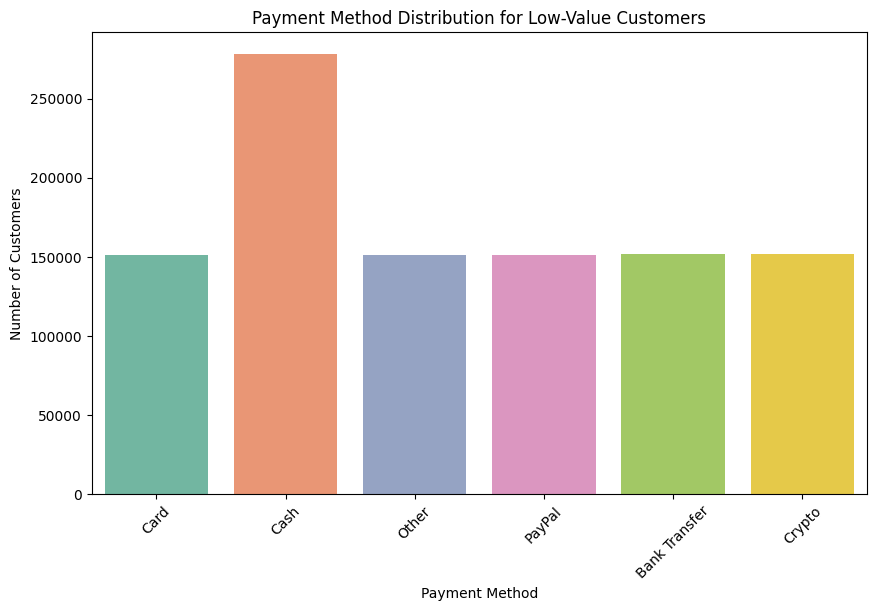

In [ ]:
# Bar plot for Payment Method distribution among low-value customers
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', data=low_value_customers, palette='Set2')
plt.title('Payment Method Distribution for Low-Value Customers')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


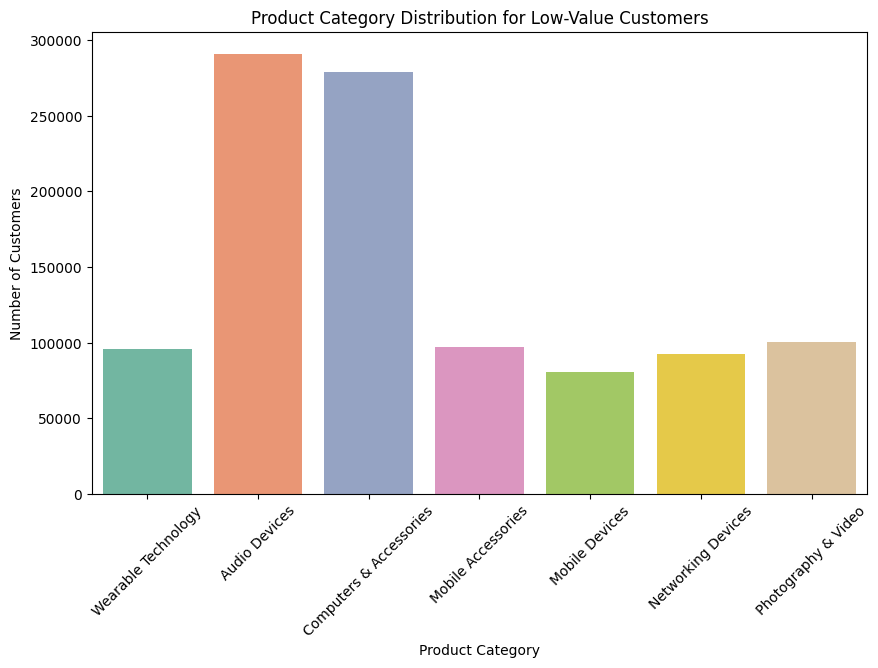

In [ ]:
# Bar plot for Payment Method distribution among low-value customers
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=low_value_customers, palette='Set2')
plt.title('Product Category Distribution for Low-Value Customers')
plt.xlabel('Product Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


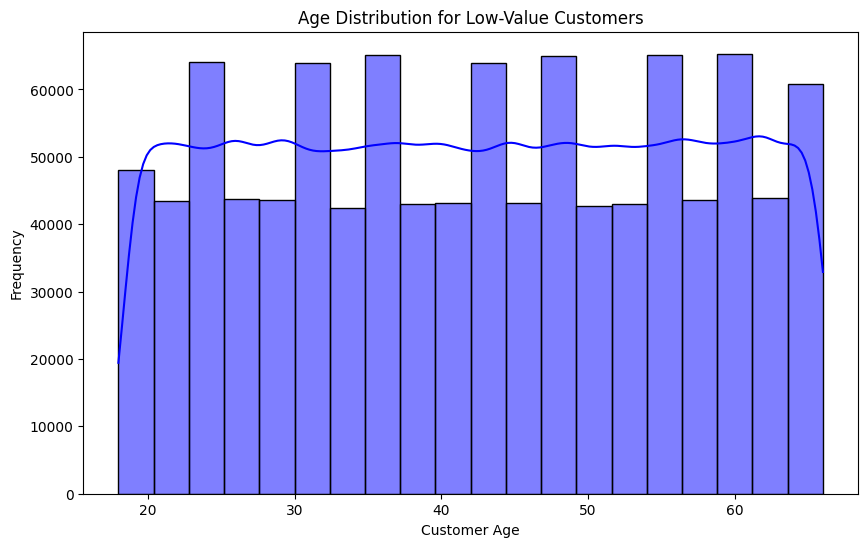

42.32547375000121


In [ ]:
# Plot histogram of Customer Age for low-value customers
plt.figure(figsize=(10, 6))
sns.histplot(low_value_customers['CustomerAge'], kde=True, color='blue', bins=20)
plt.title('Age Distribution for Low-Value Customers')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()
print(low_value_customers['CustomerAge'].mean())


In [ ]:
data.to_csv(r'C:\Users\hp\Downloads\Nonso-ml\ml_data_cleaned_rfm.csv', index=False)